# Libraries

In [1]:
from src import data # dataset functions
import pandas as pd # dataframes
import numpy as np # linear algebra
from bs4 import BeautifulSoup # html parser
import re # regular expressions
from nltk.tokenize import word_tokenize # tokenizing
from ydata_profiling import ProfileReport # data reports
import os # file operations


# visualization
import matplotlib.pyplot as plt # plotting
import seaborn as sns # high level api for matplotlib
import seaborn.objects as so # grammar of graphics

In [2]:
# plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Datasets

In [3]:
data_directory = '../../../../data/04_pubmed'
datasets = data.dict_from_directory(data_directory)

# Y-Data Profiling

In [4]:
export_path = '../../../html/3_2_2_analysis'

[ProfileReport(dataset).to_file(f'{export_path}/{subject}.html')
 for subject, dataset in datasets.items()
 if not os.path.isfile(f'{export_path}/{subject}.html')]

[]

# General Characteristics

Save one DataFrame to a variable to inspect its structure

In [5]:
# subject & data of the first dataset
subject, dataframe = next(iter(datasets.items()))
print(f'accessing the first dataset: {subject}')

accessing the first dataset: adhd


Print the first few lines

In [6]:
dataframe.head()

,include,title,abstract,doi,literature_id,openalex_id
0,False,The effectiveness of clonidine as an analgesic...,To compare the analgesic effects of preoperati...,https://doi.org/10.1007/bf03012457,10051933,https://openalex.org/W2082613933
1,False,A Controlled Trial of Sustained-Release Buprop...,Use of nicotine-replacement therapies and the ...,https://doi.org/10.1056/nejm199903043400903,10053177,https://openalex.org/W2312609348
2,False,Effects of methylphenidate on complex cognitiv...,Three experiments were conducted to explore th...,https://doi.org/10.1037/0021-843x.108.1.90,10066996,https://openalex.org/W2022904832
3,False,Spinal Clonidine Prolongs Labor Analgesia from...,We sought to determine whether spinal clonidin...,https://doi.org/10.1097/00000539-199903000-00020,10072008,https://openalex.org/W2021097359
4,False,Low-Dose Clozapine for the Treatment of Drug-I...,Drug-induced psychosis is a difficult problem ...,https://doi.org/10.1056/nejm199903113401003,10072410,https://openalex.org/W4239283954


Index, dtypes, columns, non-null values and memory usage 

In [7]:
# calculate the memory usage insted of estimating it
dataframe.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   include        851 non-null    boolean
 1   title          851 non-null    string 
 2   abstract       830 non-null    string 
 3   doi            780 non-null    string 
 4   literature_id  851 non-null    Int64  
 5   openalex_id    843 non-null    string 
dtypes: Int64(1), boolean(1), string(4)
memory usage: 2.0 MB


- Records contain the label (include), title and abstract and multiple identifiers
- The label is a boolean, the other columns are strings or numbers
- The dataframe takes 2 MB of memory

# Sample Inspection

In [8]:
pd.options.display.max_colwidth = 150

## Languages
There are abstracts in German and Japanese. As the models will not be able to handle multiple languages, we need to handle languages other than English.
As non-English entries are relatively rare, we can safely drop these few rows.

In [9]:
print(pd.concat([
    datasets['pancreatic_surgery'][['abstract']].iloc[200],
    datasets['atypical_antipsychotics'][['abstract']].iloc[99]
], axis=1).transpose())

                                                                                                                                                  abstract
200  Zusammenfassung Hintergrund Die chronische Pankreatitis (CP) ist eine haufige Ursache fur stationare Einweisungen in die Gastroenterologie und ist...
99   シグマ受容体拮抗物質に関する最近の研究成果を精神分裂病治療薬との関連でまとめた．選択的シグマ1受容体拮抗物質であるNE-100はphencyclidine(PCP)誘発異常行動改善作用および認知障害改善作用を有するが，ドパミンアゴニスト誘発行動には影響を及ぼさず，カタレプシー惹起性も認められ...


## Noise
The following examples demonstrate kinds of noise that make complicate classification for the models.

### HTML Tags


In [10]:
pd.concat([
    datasets['calcium_channel_blockers'][['abstract']].iloc[[24]],
    datasets['adhd'][['abstract']].iloc[[456, 565]]
])

,abstract
24,<h3>Objective:</h3> To report an atypical presentation of Lance-Adams Syndrome presenting from severe respiratory depression rather than cardiac a...
456,<b><i>Objective:</i></b> To evaluate the efficacy and safety of risperidone in children and adults with Tourette syndrome. <b><i>Methods:</i></b> ...
565,<h3>Objective:</h3> To compare the intraocular pressure (IOP) lowering efficacy of 0.5% and 1.0% apraclonidine hydrochloride when used adjunctivel...


We can get rid of HTML using the Beautiful Soup library, e.g. the article with index 456 from above:

In [11]:
BeautifulSoup(datasets['adhd'].iloc[456]['abstract'], 'lxml').get_text()

'Objective: To evaluate the efficacy and safety of risperidone in children and adults with Tourette syndrome. Methods: This was an 8-week, randomized, double-blind, placebo-controlled trial. The primary outcome measure was the Total Tic score of the Yale Global Tic Severity Scale (YGTSS). Results: Thirty-four medication-free subjects (26 children and 8 adults) ranging in age from 6 to 62 years (mean = 19.7 ± 17.0 years) participated. YGTSS Total Tic scores were similar at baseline (26.0 ± 5.1 for risperidone vs 27.4 ± 8.5 for placebo). After 8 weeks of treatment (mean daily dose of 2.5 ± 0.85), the 16 subjects on risperidone showed a 32% reduction in tic severity from baseline, compared to a 7% reduction for placebo patients (n = 18) (F[2,64] = 6.07; p = 0.004). The 12 children randomized to risperidone showed a 36% reduction in tic symptoms compared to an 11% decrease in the 14 children on placebo (F[2,48] = 6.38; p = 0.004). Two children on risperidone showed acute social phobia, whi

### Markdown Headings

In [12]:
datasets['calcium_channel_blockers'].iloc[[44]][['abstract']]

,abstract
44,### Table of contents It is important that the medical profession play a significant role in critically evaluating the use of diagnostic proced...


Markdown headings are defined by a number of subsequent '#'

Regular expressions can filter any sequence from zero to unlimited characters:

In [13]:
no_headings = re.sub(r'(#)+', '', datasets['calcium_channel_blockers'].iloc[[44]]['abstract'].values[0])
no_headings

' Table of contents\r\n\r\nIt is important that the medical profession play a significant role in critically evaluating the use of diagnostic procedures and therapies in the management or prevention of disease states. Rigorous and expert analysis of the available data documenting relative benefits and'

The transformation made a carriage return visible. This can also be riddened of by regular expressions:

In [14]:
re.sub(r'(\r\n\r\n)+', ' ', no_headings)

' Table of contents It is important that the medical profession play a significant role in critically evaluating the use of diagnostic procedures and therapies in the management or prevention of disease states. Rigorous and expert analysis of the available data documenting relative benefits and'

In [15]:
re.sub(r'(\\r)+(\\n)+', ' ', no_headings)

' Table of contents\r\n\r\nIt is important that the medical profession play a significant role in critically evaluating the use of diagnostic procedures and therapies in the management or prevention of disease states. Rigorous and expert analysis of the available data documenting relative benefits and'

### Special Characters
Other special characters are also possible

In [16]:
datasets['animal_depression'].iloc[190]['abstract']

'✓ Adult Fisher 344 rats were subjected to a unilateral impact to the dorsal cortex above the hippocampus at 3.5 m/second, resulting in a 2-mm cortical depression. This caused severe cortical damage and neuronal loss in hippocampus subfields CA1, CA3, and hilus. Breakdown of the blood-brain barrier (BBB) was assessed by injecting the protein horseradish peroxidase (HRP) 5 minutes prior to or at various times after injury (5 minutes, 1, 3, 6, and 12 hours, 1, 2, 5, and 10 days). Animals were killed 1 hour after HRP injection and brain sections were reacted with diaminobenzidine to visualize extravascular accumulation of the protein. Maximum staining occurred in animals injected with HRP 5 minutes prior to or 5 minutes after cortical contusion. Staining at these time points was observed in the ipsilateral cortex of the impact area and areas adjacent to it, as well as in the ipsilateral hippocampus. Some modest staining occurred in the dorsal contralateral cortex near the superior sagitta

Another approach of eliminating unwanted characters is to tokenize the text and filter by using a list of unwanted tokens:

In [17]:
tokenized = word_tokenize(datasets['animal_depression'].iloc[190]['abstract'])
stopwords = ['✓']

[word for word in tokenized if word.lower() not in stopwords][:6] + ['...']

['Adult', 'Fisher', '344', 'rats', 'were', 'subjected', '...']

### Abbreviations
You commonly find abbreviations in scientific texts.

In [18]:
datasets['pancreatic_surgery'].iloc[[1,6,249]][['abstract']]

,abstract
1,The importance of diagnostic endoscopic retrograde cholangiography (ERCP) has dramatically decreased owing to the development of less invasive tec...
6,INTRODUCTION: Pancreaticopleural fistula (PPF) is a rare but serious complication of pancreatic disorders. As the clinical presentations of PPF ar...
249,"Intravenous radionuclide cholescintigraphy (IVRC) provides a very specific picture for choledochal cysts. However, the clinical significance of th..."


However, because their meaning may differ between articles, we remove them to make the text less ambiguous.

Abbreviations usually follow the format of two or more uppercase letters, surrounded by parantheses.
We can use this format convention to filter out abbreviations using regular expressions:

In [19]:
remove_abbreviations = r'(\([A-Z]{2,}\))'# at least two uppercase letters in parentheses
sample = datasets['pancreatic_surgery'].iloc[[1]]['abstract'].values[0]

re.sub(remove_abbreviations, '', sample)

'The importance of diagnostic endoscopic retrograde cholangiography  has dramatically decreased owing to the development of less invasive techniques such as ultrasonography, computed tomography, endoscopic ultrasonography, and finally magnetic resonance cholangiopancreatography . MRCP is becoming the gold standard in the diagnostic work-up of the pancreaticobiliary duct. However, MRCP cannot solve all the problems that occur, and still has inadequate resolution for small stones and tiny pancreatic and bile duct lesions. ERCP continues to be useful in difficult cases and when the diagnosis is uncertain, particularly when fluid collection and tissue sampling are necessary. However, several alternatives to sphincter of Oddi manometry have been proposed. Finally, ERCP is always the first step before endoscopic treatment, which in contrast to diagnostic ERCP is still widely used.'

## Duplicates
There appear many duplicates when searching for articles with the same title. There are however different cases that require individual handling:

### Same article published twice
The following example shows an identical article that was published twice. Because the two articles are identical, we can safely delete one of them.

In [20]:
datasets['pancreatic_surgery'].iloc[[12250,12322]]

,include,title,abstract,doi,literature_id,openalex_id
12250,False,β-cell failure in type 2 diabetes: postulated mechanisms and prospects for prevention and treatment.,OBJECTIVE: This article examines the foundation of β-cell failure in type 2 diabetes (T2D) and suggests areas for future research on the underlyin...,10.1210/jc.2014-1425,24712577,<NA>
12322,False,β-cell failure in type 2 diabetes: postulated mechanisms and prospects for prevention and treatment.,OBJECTIVE: This article examines the foundation of β-cell failure in type 2 diabetes (T2D) and suggests areas for future research on the underlyin...,10.2337/dc14-0396,24812433,<NA>


### Same title but different articles
Another case are articles that share a title but are clearly distinguishable through their content, doi and literature id. As those two articles differ in content, we try to keep both.

In [21]:
datasets['oral_hypoglycemics'].iloc[[178,179]]

,include,title,abstract,doi,literature_id,openalex_id
178,False,Oral Antihyperglycemic Therapy for Type 2 Diabetes,"Diabetes mellitus affects more than 6% of the US population, with the great majority having type 2 diabetes mellitus (DM). 1 In some older groups,...",https://doi.org/10.1001/jama.287.3.360,11790216,https://openalex.org/W2069150029
179,False,Oral Antihyperglycemic Therapy for Type 2 Diabetes,"Oral agents are the mainstay of pharmacologic treatment for type 2 diabetes, and physicians now have a number of agents to choose from. However, m...",https://doi.org/10.1001/jama.287.3.373,11790217,https://openalex.org/W1988203022


### Same title and abstract but different literature_id

In [22]:
datasets['pancreatic_surgery'].iloc[[1421, 4664, 4666, 4668, 14868, 32546, 32935]]

,include,title,abstract,doi,literature_id,openalex_id
1421,False,Serological differences between some isolates of bean yellow mosaic virus.,The degree of serological relatedness of three isolates of bean yellow mosaic virus (BYMV) was studied. One common antigenic group (m) was demonst...,<NA>,WOS:A1992HY79500019,<NA>
4664,False,Serological differences between some isolates of bean yellow mosaic virus.,The degree of serological relatedness of three isolates of bean yellow mosaic virus (BYMV) was studied. One common antigenic group (m) was demonst...,10.1016/S0016-5107(92)70486-6,WOS:A1992JJ19200021,<NA>
4666,False,Serological differences between some isolates of bean yellow mosaic virus.,The degree of serological relatedness of three isolates of bean yellow mosaic virus (BYMV) was studied. One common antigenic group (m) was demonst...,<NA>,WOS:A1992JJ53700003,<NA>
4668,False,Serological differences between some isolates of bean yellow mosaic virus.,The degree of serological relatedness of three isolates of bean yellow mosaic virus (BYMV) was studied. One common antigenic group (m) was demonst...,<NA>,WOS:A1992JL18000002,<NA>
14868,False,Serological differences between some isolates of bean yellow mosaic virus.,The degree of serological relatedness of three isolates of bean yellow mosaic virus (BYMV) was studied. One common antigenic group (m) was demonst...,<NA>,WOS:A1992HV16000003,<NA>
32546,False,Serological differences between some isolates of bean yellow mosaic virus.,The degree of serological relatedness of three isolates of bean yellow mosaic virus (BYMV) was studied. One common antigenic group (m) was demonst...,<NA>,WOS:A1992HH62100002,<NA>
32935,False,Serological differences between some isolates of bean yellow mosaic virus.,The degree of serological relatedness of three isolates of bean yellow mosaic virus (BYMV) was studied. One common antigenic group (m) was demonst...,10.1016/0016-5085(92)91195-A,WOS:A1992JV47800035,<NA>


### Same title but different labels
- Following the literature_id reveals different titles

In [48]:
datasets['pancreatic_surgery'].iloc[[30701, 32679, 32680, 32853, 33022, 33088, 33119]]


,include,title,abstract,doi,literature_id,openalex_id
30701,True,Selection of chlortetracycline-resistant strain of Coxiella burnetii.,<NA>,<NA>,WOS:A1997YL29400007,<NA>
32679,False,Selection of chlortetracycline-resistant strain of Coxiella burnetii.,<NA>,10.1016/S1053-4296(97)80053-7,WOS:A1997XM14200001,<NA>
32680,False,Selection of chlortetracycline-resistant strain of Coxiella burnetii.,<NA>,<NA>,WOS:A1997XM38400008,<NA>
32853,False,Selection of chlortetracycline-resistant strain of Coxiella burnetii.,<NA>,<NA>,WOS:A1997YK06400008,<NA>
33022,False,Selection of chlortetracycline-resistant strain of Coxiella burnetii.,<NA>,10.1016/S0039-6060(97)90175-6,WOS:A1997WC21200001,<NA>
33088,True,Selection of chlortetracycline-resistant strain of Coxiella burnetii.,<NA>,<NA>,WOS:A1997WV41901011,<NA>
33119,True,Selection of chlortetracycline-resistant strain of Coxiella burnetii.,<NA>,<NA>,WOS:A1997WV41905901,<NA>


## Paragraph Labels

In [26]:
pd.concat([
    datasets['pancreatic_surgery'].iloc[[3,4,6,9,12,13,19,21,23,31,307,343,399,430,533,656,876,]][['abstract']],
    datasets['atypical_antipsychotics'].iloc[[24]][['abstract']],
    datasets['adhd'].iloc[[39]][['abstract']]
])

,abstract
3,BACKGROUND: Gastric lipase contributes significantly to overall lipolysis and is regulated by interacting neuro-hormonal mechanisms. Patients with...
4,BACKGROUND/AIM: The pancreas is an organ highly susceptible to ischemic damage. This discussion reviews the role of ischemia as an etiologic facto...
6,INTRODUCTION: Pancreaticopleural fistula (PPF) is a rare but serious complication of pancreatic disorders. As the clinical presentations of PPF ar...
9,UNLABELLED: Tacrolimus (FK-506) is an immunosuppressant agent that acts by a variety of different mechanisms which include inhibition of calcineur...
12,INTERVENTION: Precompression of pancreatic parenchyma with intestinal clamp. Without Precompression CONDITION: Patients who underwent distal pancr...
13,Objective The aim of this study was to report on the short-and long-term outcomes of surgery for chronic pancreatitis (CP) in children. Methods Al...
19,"Although type 1 and type 2 diabetes represent the vast majority of affected individuals with the disease, not all cases of diabetes fit neatly int..."
21,OBJECTIVE: The ISGPS aimed to develop a universally accepted definition for PPAP for standardized reporting and outcome comparison. BACKGROUND: PP...
23,"OBJECTIVE: To review the current literature pertaining to the pathophysiology, diagnosis, and treatment of injuries sustained from high-rise syndr..."
31,BACKGROUNDS/OBJECTIVES: Patients with chronic pancreatitis may develop pancreatic duct stones that can obstruct outflow leading to ductal hyperten...


# Missing Values

- How many titles and abstracts are missing?
- How many more were missing before downloading data from PubMed?

In [27]:
data_directory_before = '../../../../data/03_openalex'
datasets_before = data.dict_from_directory(data_directory_before)

Calculate missing titles & abstracts before and after the data retrieval:

In [28]:
missing_percentages = lambda x: round(x.isna().mean() * 100, 2)

In [29]:
missings_before = pd.DataFrame({
    'dataset': subject,
    'title': missing_percentages(df['title']),
    'abstract': missing_percentages(df['abstract']),
    'preprocessing': 'before'
}for subject, df in datasets_before.items())

In [30]:
missings_after = pd.DataFrame({
    'dataset': subject,
    'title': missing_percentages(df['title']),
    'abstract': missing_percentages(df['abstract']),
    'preprocessing': 'after'
}for subject, df in datasets.items())

In [31]:
missings = pd.concat([missings_before, missings_after])

missings_long = pd.melt(missings, id_vars=['dataset', 'preprocessing'], value_vars=['title', 'abstract'],
                        var_name='type', value_name='missing')

missings_long.sort_values(by='preprocessing', ascending=True, inplace=True)

missings_long

,dataset,preprocessing,type,missing
11,pancreatic_surgery,after,title,0.02
21,calcium_channel_blockers,after,abstract,3.53
20,atypical_antipsychotics,after,abstract,2.59
19,animal_depression,after,abstract,12.84
18,adhd,after,abstract,2.47
22,oral_hypoglycemics,after,abstract,3.78
10,oral_hypoglycemics,after,title,0.00
9,calcium_channel_blockers,after,title,0.00
23,pancreatic_surgery,after,abstract,8.74
7,animal_depression,after,title,2.71


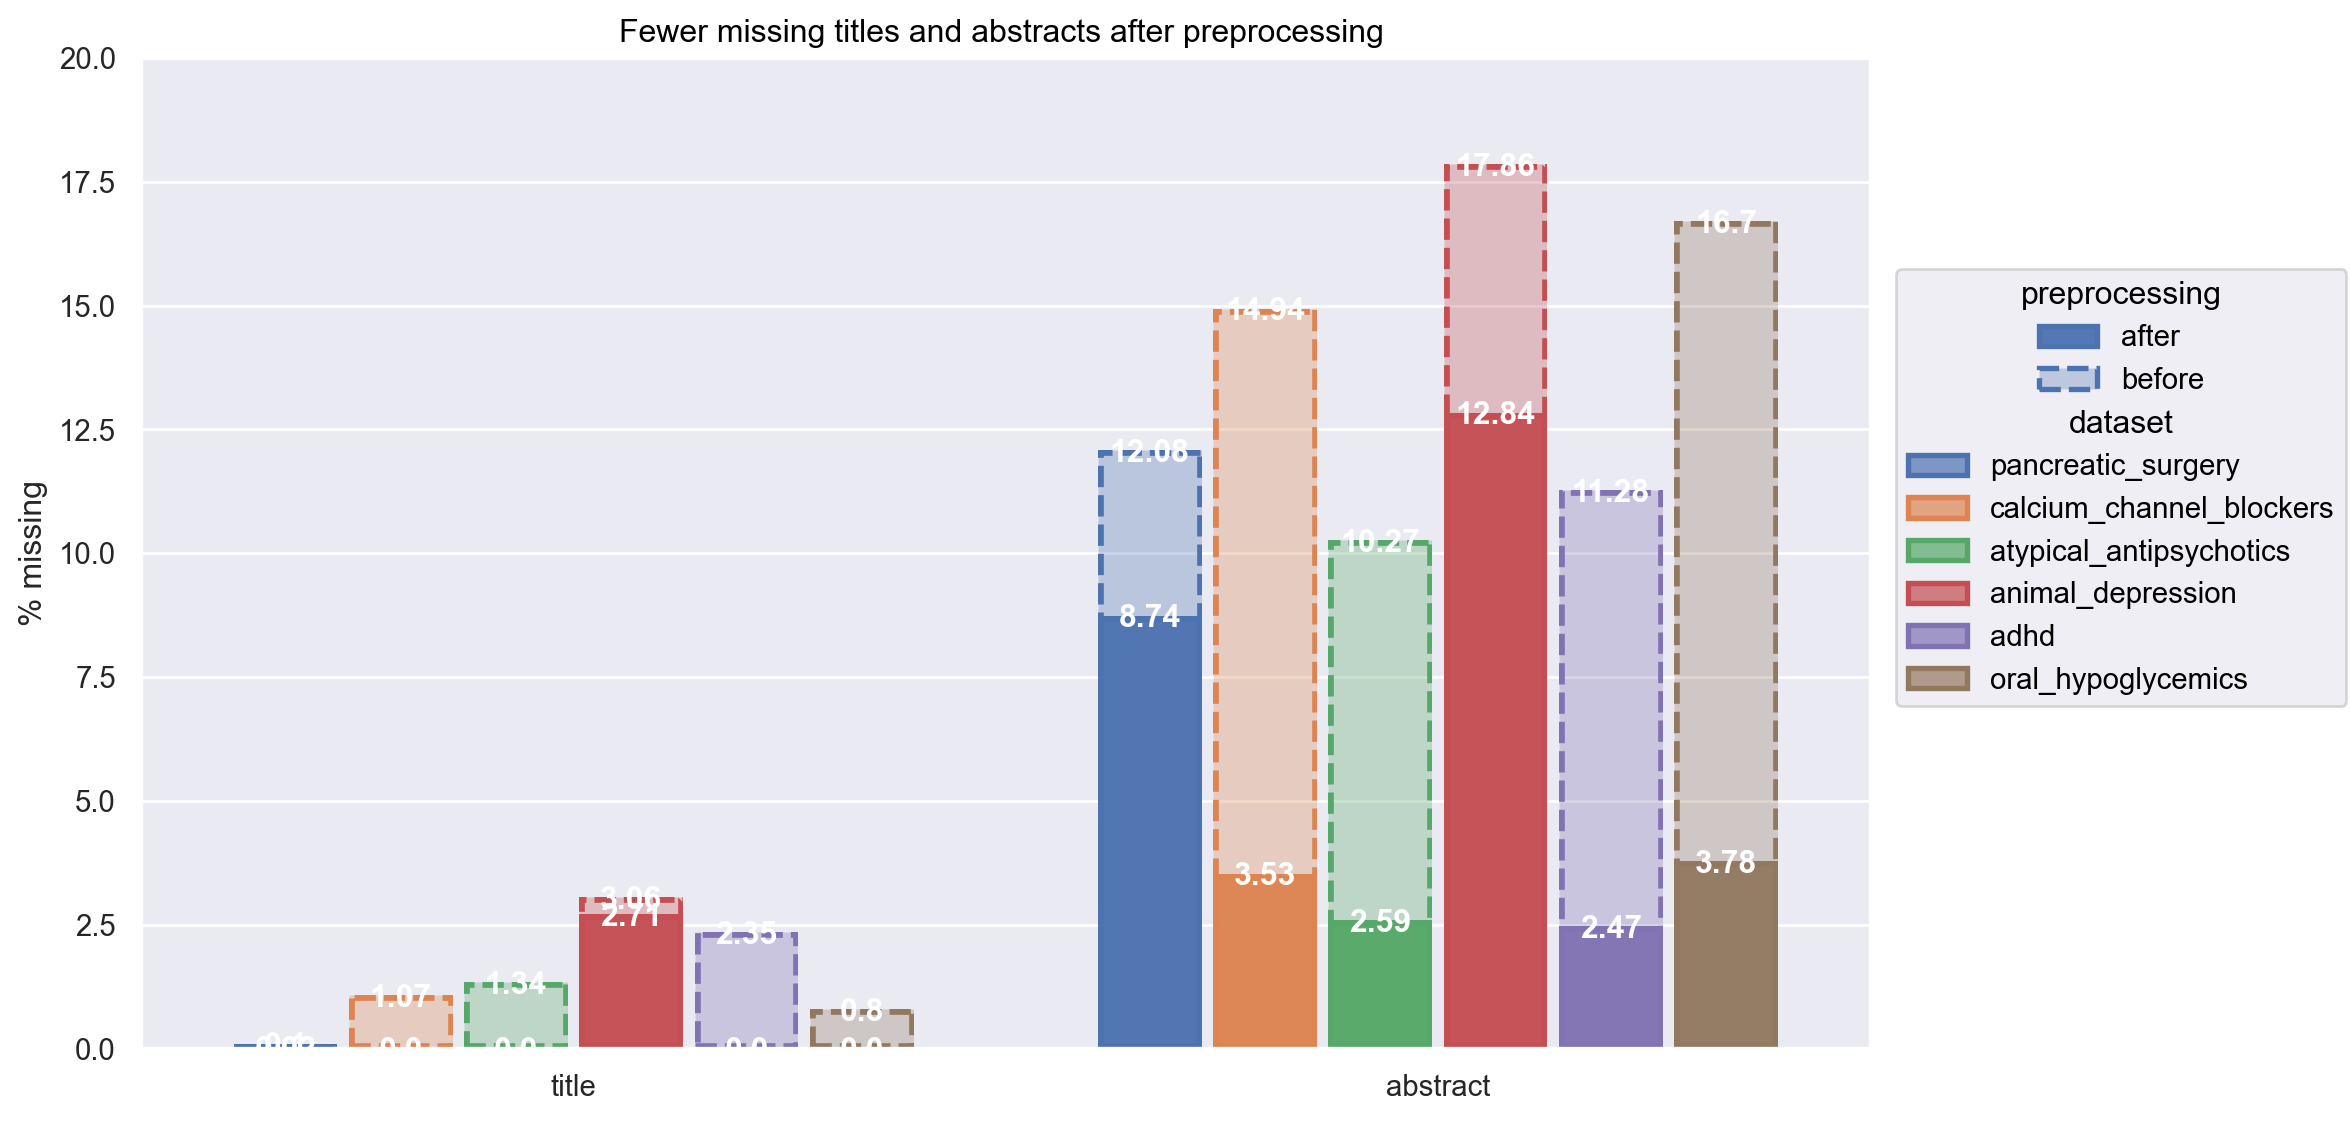

In [32]:
(
    so.Plot(data=missings_long, x='type', y='missing', alpha='preprocessing', edgestyle='preprocessing', color='dataset', text='missing')
    .add(so.Bar(edgewidth=2), so.Dodge(by=['color'], gap=0.1))
    .add(so.Text({"fontweight": "bold"}, color='w', alpha=1), so.Dodge(by=['color']))
    .label(x='', y='% missing', title='Fewer missing titles and abstracts after preprocessing ', legend='Test')
    .scale()
    .layout(size=(10, 6))
    .limit(y=(0,20))
)

# Label Distributions

In [33]:
frequency_distribution = lambda x: x.value_counts(normalize=True)

In [34]:
distributions = pd.DataFrame({
    'dataset': subject,
    'include ': round((df.include.pipe(frequency_distribution)[True] * 100), 2),
    'exclude': round((df.include.pipe(frequency_distribution)[False] * 100), 2),
}for subject, df in datasets.items())

## Display the percentages of distributions in a table

In [35]:
distributions

,dataset,include,exclude
0,adhd,2.35,97.65
1,animal_depression,14.05,85.95
2,atypical_antipsychotics,13.04,86.96
3,calcium_channel_blockers,8.21,91.79
4,oral_hypoglycemics,27.04,72.96
5,pancreatic_surgery,6.88,93.12


## Plot a graph with the inclusion percentages

In [36]:
distributions_melted = distributions.melt(id_vars='dataset', value_name='percentage')
distributions_melted.sort_values(by='percentage', ascending=False, inplace=True)
distributions_melted

,dataset,variable,percentage
6,adhd,exclude,97.65
11,pancreatic_surgery,exclude,93.12
9,calcium_channel_blockers,exclude,91.79
8,atypical_antipsychotics,exclude,86.96
7,animal_depression,exclude,85.95
10,oral_hypoglycemics,exclude,72.96
4,oral_hypoglycemics,include,27.04
1,animal_depression,include,14.05
2,atypical_antipsychotics,include,13.04
3,calcium_channel_blockers,include,8.21


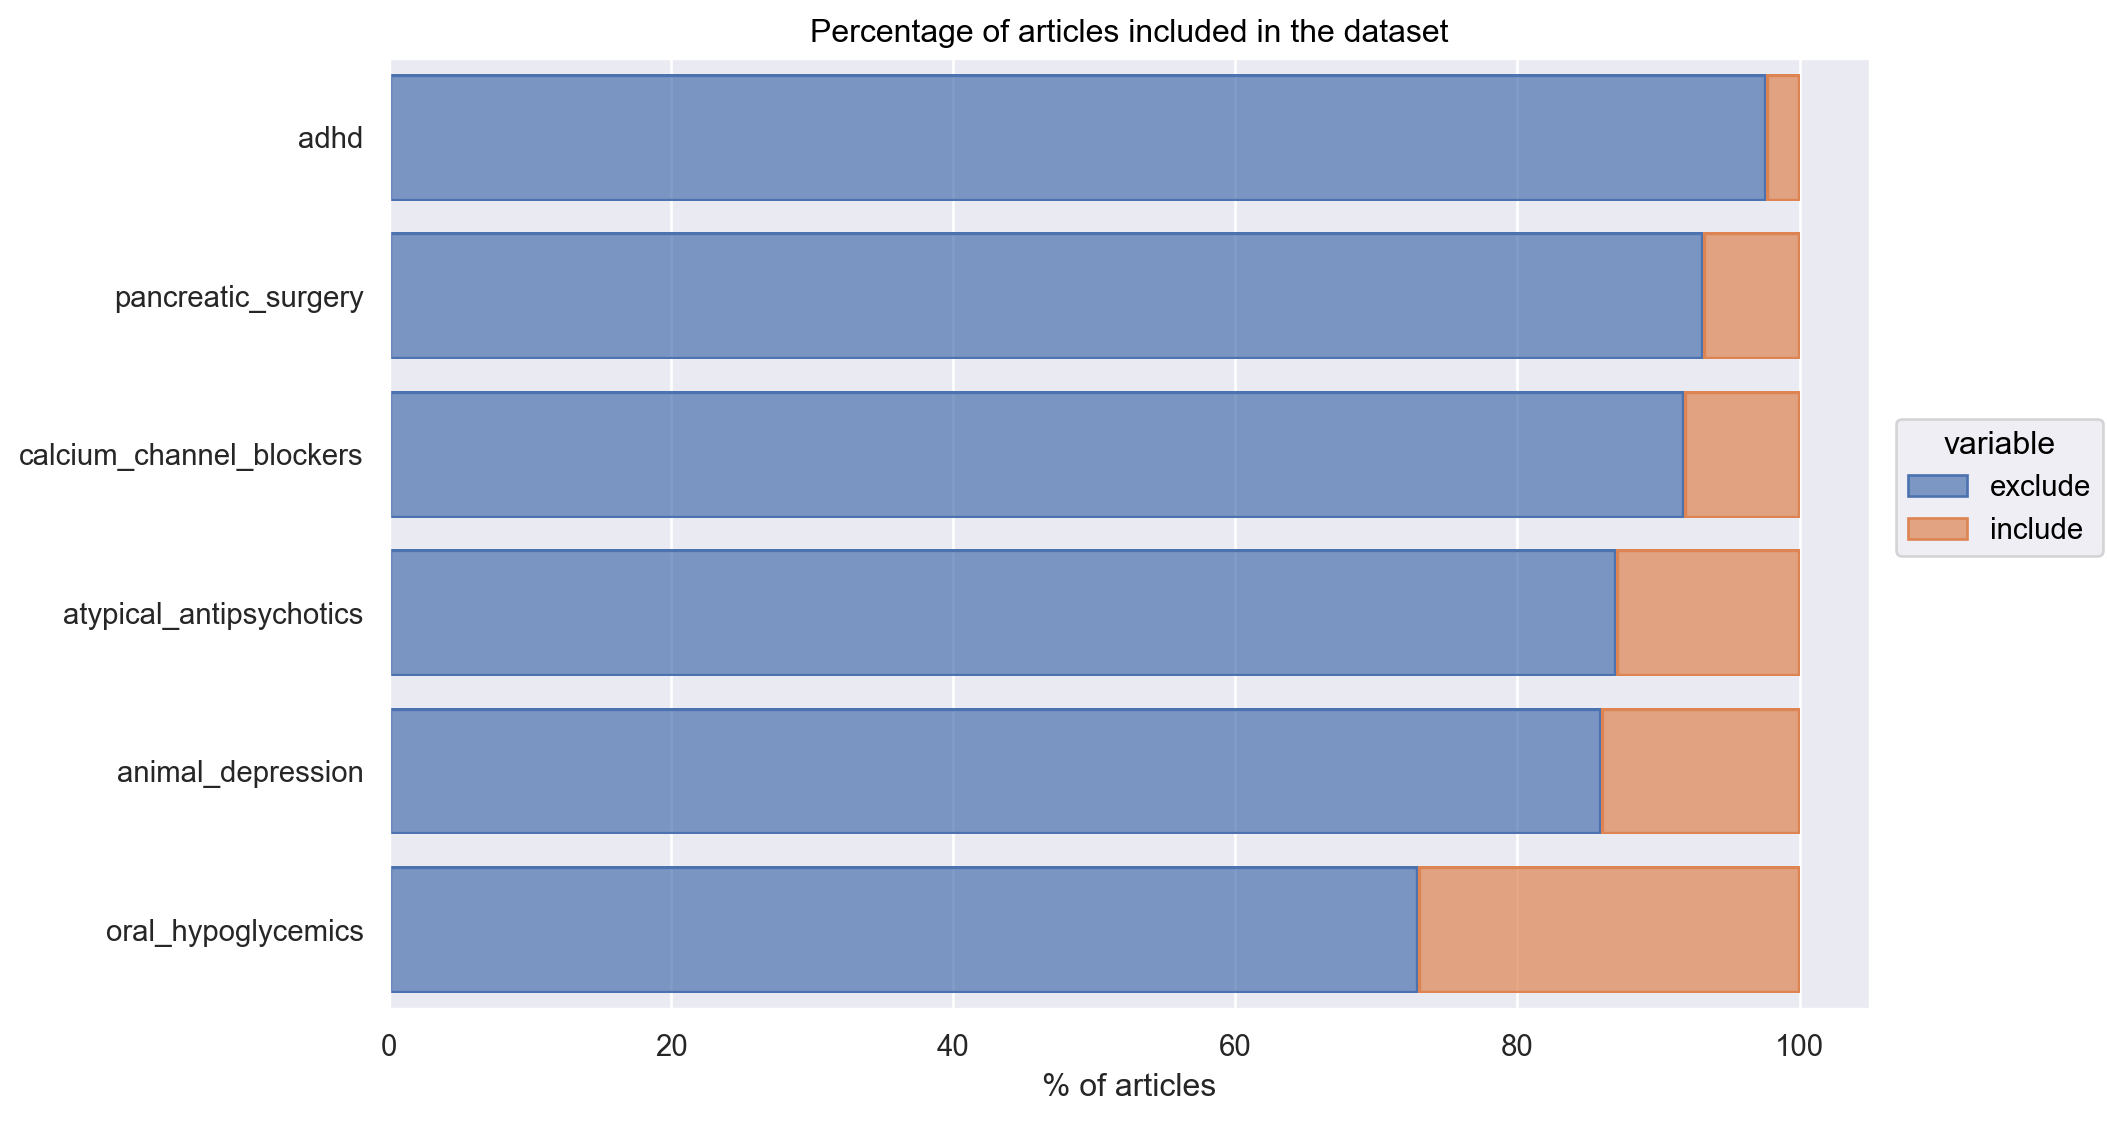

In [37]:
(
    so.Plot(data=distributions_melted, y='dataset', x='percentage', color='variable')
    .add(so.Bar(), so.Stack())
    .label(y='', x='% of articles', title='Percentage of articles included in the dataset')
    .layout(size=(10, 6))
)